In [1]:
%%system
rm /scratch/ors -r
mkdir /scratch/ors
mkdir /scratch/ors/clr
mkdir /scratch/ors/dmg
cp ~/ors-project/data.tar.gz /scratch/ors
tar -xzvf /scratch/ors/data.tar.gz --directory /scratch/ors/
mv /scratch/ors/patches_256_v2 /scratch/ors/clr

["rm: cannot remove '/scratch/ors': No such file or directory",
 'patches_256_v2/',
 'patches_256_v2/47241882b3ec18350d5cf9f2b2ae7126.png',
 'patches_256_v2/f3bc77c7c77490d57feb757311ec78d0.png',
 'patches_256_v2/853c1077ca1750b4a4f13fc5bf49c0d1.png',
 'patches_256_v2/271b8741f4669704c795e04c8dc054b9.png',
 'patches_256_v2/33e98642af577a500dffd3936629ebe7.png',
 'patches_256_v2/44a924d539458dd0c490340ab9a611c4.png',
 'patches_256_v2/271b38b5c8419709160b5365bee967a5.png',
 'patches_256_v2/8d899ea6c7ccc62206e4243b8ab40fbe.png',
 'patches_256_v2/ecf50e585ecbe7a69a26807143e56c4c.png',
 'patches_256_v2/4f770737e533fefeb5e02d8010dbfad4.png',
 'patches_256_v2/dba15f7ceea4841b2ec46045d6d6b71c.png',
 'patches_256_v2/5fb27c8713f6c4d03814ac853ff47acf.png',
 'patches_256_v2/77a70f7a45892ec3cfb60138621567ee.png',
 'patches_256_v2/23a476f783cc6effd207ae81926dd8f2.png',
 'patches_256_v2/4c061e4b40febe21e4e70b6b7f861790.png',
 'patches_256_v2/b366346cb994faf4e6a562dab306cf02.png',
 'patches_256_v2/c71

In [1]:
import numpy as np
from PIL import Image, ImageDraw
from random import randint
import random
import matplotlib.pyplot as plt
from pathlib import Path
from fastai.vision.all import *

In [2]:
path = Path("/scratch/ors/")
path_clear = path/"clr"
path_damaged = path/"dmg"

In [3]:
LINE_WIDTH = 2
STRIP_IMAGE_SIZE = 512

In [4]:
def damage_image(image_path):    
    stripes_base = Image.new("RGB", (STRIP_IMAGE_SIZE, STRIP_IMAGE_SIZE), (255, 255, 255))
    stripes = ImageDraw.Draw(stripes_base)

    
    color = [0, 0, 0]
#     color = [255, 255, 255]
#     color[random.randint(0, 2)] = 0
    color = tuple(color)

    for y in range(int(1.1 * LINE_WIDTH), int(STRIP_IMAGE_SIZE - 0.1 * LINE_WIDTH), 20):
        stripes.line([0, y, STRIP_IMAGE_SIZE, y], width=LINE_WIDTH, fill=color)
    
    damage_lines = stripes_base.rotate(random.randint(0, 360))
    damage_lines = damage_lines.crop(((STRIP_IMAGE_SIZE - 256)/2, (STRIP_IMAGE_SIZE - 256)/2, (STRIP_IMAGE_SIZE + 256)/2, (STRIP_IMAGE_SIZE + 256)/2, ))
    damage_lines = np.array(damage_lines) / 255
    
    img = Image.open(image_path)
    img = np.array(img) / 255
    damaged_img = img * damage_lines
    damaged_img = np.uint8(damaged_img * 255)
    damaged_img = Image.fromarray(damaged_img)
    damaged_img.save(path_damaged/image_path.name)

In [38]:
parallel(damage_image, path_clear.ls(), n_workers=8, progress=True)

(#12900) [None,None,None,None,None,None,None,None,None,None...]

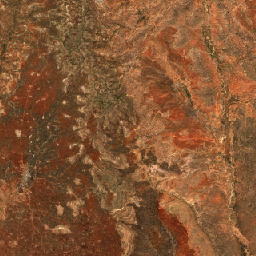

In [5]:
clear_image = Image.open("/scratch/ors/clr/4444f764fb25a7041fb9c883dcef3dbb.png")
clear_image

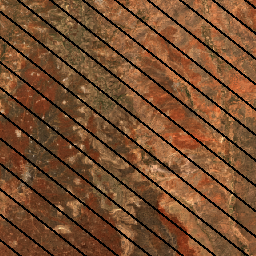

In [6]:
damaged_image = Image.open("/scratch/ors/dmg/4444f764fb25a7041fb9c883dcef3dbb.png")
damaged_image

In [7]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                  get_items=get_image_files,
                  get_y=lambda x: path_clear/x.name,
                  splitter=RandomSplitter(),
                  item_tfms=Resize(224),
                  batch_tfms=[*aug_transforms(max_zoom=2.),
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = dblock.dataloaders(path_damaged, bs=8)

/home2/s.ranjan/miniconda3/envs/ors/lib/python3.6/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [9]:
dls_gen = dls
dls_gen.c = 3

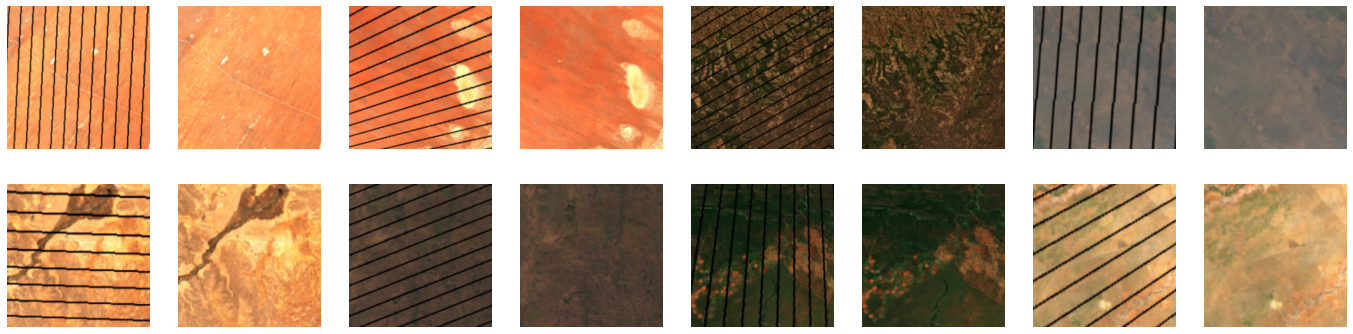

In [10]:
dls_gen.show_batch()

In [11]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [12]:
bbone = resnet34

In [13]:
def create_gen_learner():
    return unet_learner(dls_gen, bbone, loss_func=loss_gen)

In [14]:
learn_gen = create_gen_learner()

In [15]:
learn_gen.load("image_restoration_striped_lines")

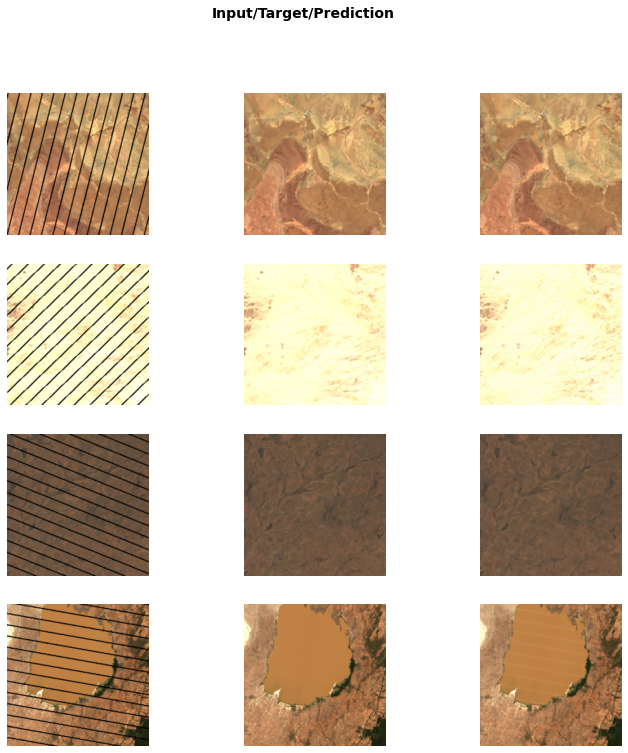

In [16]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [23]:
model_pred = learn_gen.predict(path_damaged/"4444f764fb25a7041fb9c883dcef3dbb.png")

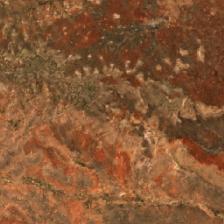

In [36]:
repaired_image = Image.fromarray(model_pred[0].T.numpy().astype("uint8"))
repaired_image